### Regression notebook for Wadhwani AI competition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import gc
import random
from glob import glob
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import warnings
import pickle
import json
import re
import time
import sys
from requests import get
import multiprocessing
import joblib
import torch
from torch.utils.data import Dataset, DataLoader
import transformers
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import timm
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2,torchvision
from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
from timm.optim.optim_factory import create_optimizer_v2
from timm import utils
from fastprogress.fastprogress import format_time
from fastai.vision.all import *


class CFG:
    seed = 46
    n_splits = 5
    SZ = 1024
    debug = False
    BS = 20
    EP = 10
    MODEL = 'tf_efficientnet_b0_ns'
    LR = 5e-03
    WD = 1e-08

random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)
plt.rcParams["font.size"] = 13
warnings.filterwarnings('ignore')

In [2]:
set_seed(CFG.seed)

In [3]:
DIR = '///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/'
IMG_PATH = '///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/images'
submit = pd.read_csv(os.path.join(DIR,'SampleSubmission.csv'))
train = pd.read_csv(os.path.join(DIR,'Train.csv'))
test_df = pd.read_csv(os.path.join(DIR,'Test.csv'))

VERSION = "NB_EXP_V0_007_Regression"
MODEL_FOLDER = Path(f"///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/runs/Regression/{VERSION}/")
os.makedirs(MODEL_FOLDER,exist_ok=True)
KERNEL_TYPE = f"{CFG.MODEL}_{CFG.SZ}_bs{CFG.BS}_ep{CFG.EP}_lr{str(CFG.LR).replace('-','')}_wd{str(CFG.WD).replace('-','')}"

print(MODEL_FOLDER)
print(KERNEL_TYPE)

/mnt/c/Personal/Competitions/Zindi/Wadhwani AI/runs/Regression/NB_EXP_V0_007_Regression
tf_efficientnet_b0_ns_1024_bs20_ep10_lr0.005_wd1e08


In [4]:
def make_train_dataset():
    train_new_pbw = pd.DataFrame()
    train_new_pbw['image_id_worm']= train['image_id_worm'].unique()
    train_new_pbw = pd.merge(train_new_pbw,train[train['worm_type']=='pbw'].reset_index(drop=True),on='image_id_worm',how='left')
    train_new_pbw['worm_type'] = 'pbw'
    train_new_pbw.fillna(0,inplace=True)
    
    train_new_abw = pd.DataFrame()
    train_new_abw['image_id_worm']= train['image_id_worm'].unique()
    train_new_abw = pd.merge(train_new_abw,train[train['worm_type']=='abw'].reset_index(drop=True),on='image_id_worm',how='left')
    train_new_abw['worm_type'] = 'abw'
    train_new_abw.fillna(0,inplace=True)
    
    train_out = pd.concat([train_new_pbw,train_new_abw],0).reset_index(drop=True)
    
    assert len(train_out) == train['image_id_worm'].nunique()*2
    train_out = pd.pivot(train_out,'image_id_worm','worm_type','number_of_worms').reset_index()
    train_out[['abw','pbw']] = train_out[['abw','pbw']].astype(int)
    
    labels = [f'{i}' for i in range(10)]
    train_out['abw_bins'] = pd.cut(train_out['abw'],10,labels=labels)
    train_out['pbw_bins'] = pd.cut(train_out['pbw'],10,labels=labels)
    train_out['consol_bins'] = train_out['abw_bins'].astype(str)+'_'+train_out['pbw_bins'].astype(str)
    
#     train_out = train_out[['image_id_worm','abw','pbw','abw_bins','pbw_bins','consol_bins']]
    return train_out

train_new = make_train_dataset()

In [5]:
train_new.head(1)

worm_type,image_id_worm,abw,pbw,abw_bins,pbw_bins,consol_bins
0,id_0002ea6f15c7fa6f4c221783.jpg,0,51,0,0,0_0


In [6]:
train_new.shape

(9737, 6)

### Get kfolds

In [7]:
train_files = []
val_files = []
fold = []

for folds in [0,1,2,3,4]:
    files = list(pd.read_csv(f'///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/splits/fold{folds}.txt',header=None)[0].apply(lambda x:x.split("/")[-1]))
    fold.append([folds]*len(files))
    train_files.append(files)

train_files= ([item for sublist in train_files for item in sublist])
fold= ([item for sublist in fold for item in sublist])
fold_dict = dict(zip(train_files,fold))

In [8]:
train_new['fold'] = train_new['image_id_worm'].map(fold_dict)
# train_new['fold'].fillna(5,inplace=True)

In [9]:
train_new.shape

(9737, 7)

In [10]:
train_new['fold'].value_counts()

0.0    1418
4.0    1417
3.0    1417
1.0    1416
2.0    1411
Name: fold, dtype: int64

In [11]:
train_new['fold'].isna().sum()

2658

In [12]:
test_df.head(1)

,image_id_worm
0,id_00332970f80fa9a47a39516d.jpg


#### Data loader

In [13]:
IMG_PATH

'///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/images'

In [14]:
class WadhwaniDataset(Dataset):
    def __init__(self,
                 df=train_new,
                 mode='train',
                augs = None):
        
        self.augs = augs
        self.df = df
        self.mode  = mode
        
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, ix):
        image_id = self.df.loc[ix,'image_id_worm']
        img_path = f'{IMG_PATH}/{image_id}'
        
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)
        
        if self.augs is not None:
            img = self.augs(image=img)['image']
    
        if self.mode == 'test':
            return img
        
        label = torch.tensor(self.df[['abw','pbw']].loc[ix]).float()
#         label_pbw = torch.tensor(self.df['pbw'].loc[ix]).long()
        return img, label

In [15]:
def worker_init_fn(worker_id):
    """
    Handles PyTorch x Numpy seeding issues.
    Args:
        worker_id (int): Id of the worker.
    """
    np.random.seed(np.random.get_state()[1][0] + worker_id)

### Augmentations

In [16]:

TRAIN_AUG = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(rotate_limit=45, border_mode=0, p=0.75),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1,p=0.75),
    A.Blur(p=0.5),
#     A.CLAHE(p=0.5),
    A.Resize(CFG.SZ,CFG.SZ,p=1),
    A.Normalize(),
    ToTensorV2(),
])

VALID_AUG = A.Compose([
    A.Resize(CFG.SZ,CFG.SZ,p=1),
    A.Normalize(),
    ToTensorV2(),
])

### Visualization

<AxesSubplot: >

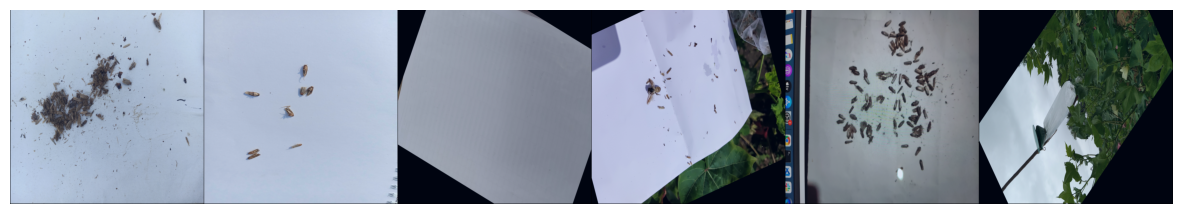

In [17]:
dataset_show = WadhwaniDataset(train_new, augs=TRAIN_AUG, mode='train')
loader_show = torch.utils.data.DataLoader(dataset_show, batch_size=6)
img,target = next(iter(loader_show))

grid = torchvision.utils.make_grid(img, normalize=True, padding=2)
grid = grid.permute(1, 2, 0)
show_image(grid, figsize=(15,8))#, title=[labels_class_map_rev[x] for x in target.numpy()]);

### Model

In [18]:
def get_wadhwani_regression_model(model_name, pretrained=True, **kwargs):
    model = timm.create_model(model_name, pretrained=pretrained, **kwargs)
    #model.set_grad_checkpointing(enable=True)
    model = nn.Sequential(model, nn.Dropout(0.15), nn.Linear(model.num_classes, 2),nn.ReLU())
    return model

In [19]:
dl = DataLoader(WadhwaniDataset(train_new, augs=TRAIN_AUG, mode='train'),
                          batch_size=2,
                          shuffle=True,
                          num_workers=8,
                          drop_last=True,
                        worker_init_fn=worker_init_fn)

a,b = next(iter(dl))
a.shape,b[0].shape,b[1].shape

(torch.Size([2, 3, 1024, 1024]), torch.Size([2]), torch.Size([2]))

In [20]:
m = get_wadhwani_regression_model(CFG.MODEL)
out = m(a)
print(out, out.shape)

tensor([[0.0000, 0.1197],
        [0.4314, 0.0000]], grad_fn=<ReluBackward0>) torch.Size([2, 2])


In [21]:
nn.L1Loss()(out,b).item()

2.327925682067871

### Train & Validation Function

In [22]:
def train_one_epoch(
    model: nn.Module,
    loader: Iterable,
    loss_fn: Callable,
    optimizer: torch.optim.Optimizer,
    lr_scheduler: torch.optim.lr_scheduler._LRScheduler = None,
    mixup_fn: Callable = None,
    grad_scaler: torch.cuda.amp.GradScaler = None,
    mbar: master_bar = None,
):

    model.train()

    losses_m = utils.AverageMeter()

    pbar = progress_bar(loader, parent=mbar, leave=False)
    pbar.update(0)

    for batch_idx, (input, target) in enumerate(loader):
        input, target = input.cuda(), target.cuda()
        
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=True):
            output = model(input)
            loss = loss_fn(output, target)
            
        losses_m.update(loss.item(), input.size(0))

        grad_scaler.scale(loss).backward()
        grad_scaler.step(optimizer)
        grad_scaler.update()

        if lr_scheduler is not None:
            lr_scheduler.step()

        pbar.update(batch_idx + 1)
        pbar.comment = f"{losses_m.avg:.4f}"

    pbar.on_iter_end()
    return OrderedDict([("loss", losses_m.avg)])


@torch.inference_mode()
def validate(model: nn.Module, loader: Iterable, loss_fn: Callable, mbar: master_bar):
    model.eval()

    l1_loss_m = utils.AverageMeter()
    losses_m = utils.AverageMeter()

    pbar = progress_bar(loader, parent=mbar, leave=False)
    pbar.update(0)

    for batch_idx, (input, target) in enumerate(loader):
        
        input, target = input.cuda(), target.cuda()
        output = torch.round(model(input))

        loss = loss_fn(output, target).item()
        losses_m.update(loss, input.size(0))

        l1_loss = nn.L1Loss()(output, target).item()
        l1_loss_m.update(l1_loss, output.size(0))

        pbar.update(batch_idx + 1)

    pbar.on_iter_end()
    return OrderedDict([("loss", losses_m.avg), ("l1_loss", l1_loss_m.avg)])


### Run!

In [23]:
train_new = train_new[~train_new['fold'].isna()].reset_index(drop=True)
train_new['fold'] = train_new['fold'].astype(int)

In [24]:
def training_loop(fold):
    
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        print()
        print("*" * 100)
        print(f"Training fold {fold}")
        print("*" * 100)

        torch.backends.cudnn.benchmark = True

        dataset_train = WadhwaniDataset(train_new.query("fold!=@fold").reset_index(drop=True), augs=TRAIN_AUG, mode="train")
        dataset_valid = WadhwaniDataset(train_new.query("fold==@fold").reset_index(drop=True), augs=VALID_AUG, mode="valid")

        print(f"TRAIN: {len(dataset_train)} | VALID: {len(dataset_valid)}")

        loader_train = torch.utils.data.DataLoader(dataset_train, CFG.BS, num_workers=8, shuffle=True, drop_last=True)
        loader_valid = torch.utils.data.DataLoader(dataset_valid, CFG.BS , num_workers=8, shuffle=False)

        model = get_wadhwani_regression_model(CFG.MODEL, pretrained=True, drop_path_rate=0.15)
        model.cuda()
        # adamw
        optimizer = create_optimizer_v2(model, "lookahead_RAdam", lr=CFG.LR, weight_decay=CFG.WD, layer_decay=0.9)

        num_train_steps = len(loader_train) * CFG.EP
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_train_steps)

        train_loss_fn = nn.L1Loss()
        valid_loss_fn = nn.L1Loss()

        grad_scaler = torch.cuda.amp.GradScaler()

        print(f"Scheduled epochs: {CFG.EP}")

        mbar = master_bar(list(range(CFG.EP)))
        best_epoch, best_metric = 0, 100000
        metric_names = ["epoch", "train_loss", "valid_loss", "l1_loss", "time"]
        mbar.write([f"{l:.6f}" if isinstance(l, float) else str(l) for l in metric_names], table=True)

        for epoch in range(CFG.EP):
            start_time = time.time()
            mbar.update(epoch)

            train_metrics = train_one_epoch(
                model, loader_train, train_loss_fn, optimizer,
                lr_scheduler=lr_scheduler, mixup_fn=None, grad_scaler=grad_scaler, mbar=mbar)

            valid_metrics = validate(model, loader_valid, valid_loss_fn, mbar=mbar)
            
            elapsed = format_time(time.time() - start_time)
            epoch_log = [epoch,train_metrics["loss"], valid_metrics["loss"], valid_metrics["l1_loss"], elapsed]
            mbar.write([f"{l:.6f}" if isinstance(l, float) else str(l) for l in epoch_log], table=True)

            if valid_metrics["l1_loss"] < best_metric:
                best_epoch, best_metric = epoch, valid_metrics["l1_loss"]
                dirpath = MODEL_FOLDER / (KERNEL_TYPE + f"_CV_{fold}.pth")
                torch.save(model.state_dict(), dirpath)

        mbar.on_iter_end()
        print("*** Best metric: {0} (epoch {1})".format(best_metric, best_epoch))

In [25]:
for fold_idx in range(5):
    training_loop(fold_idx)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 4090 (24564 RAM)


****************************************************************************************************
Training fold 0
****************************************************************************************************
TRAIN: 5661 | VALID: 1418
Scheduled epochs: 10


epoch,train_loss,valid_loss,l1_loss,time
0,5.562868,4.198872,4.198872,05:36
1,4.318847,4.010931,4.010931,05:12
2,3.877123,3.543724,3.543724,05:16
3,3.466389,3.805712,3.805712,05:02
4,3.162912,2.850494,2.850494,04:58
5,2.822758,2.618124,2.618124,05:00
6,2.456767,2.585684,2.585684,05:01
7,2.144764,2.328632,2.328632,04:58
8,1.878863,2.261989,2.261989,04:58
9,1.784746,2.201340,2.201340,04:56


*** Best metric: 2.201339962199982 (epoch 9)
CPU: 2028/244/7586 MB | GPU: 1908/20906/3648 MB | Time 0:51:02.241 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 4090 (24564 RAM)


****************************************************************************************************
Training fold 1
****************************************************************************************************
TRAIN: 5663 | VALID: 1416
Scheduled epochs: 10


epoch,train_loss,valid_loss,l1_loss,time
0,5.805388,3.515537,3.515537,05:02
1,4.314799,3.119703,3.119703,04:59
2,4.039562,4.214336,4.214336,04:57
3,3.723283,2.470692,2.470692,04:57
4,3.079342,2.248234,2.248234,04:59
5,2.941010,2.354167,2.354167,05:00
6,2.461903,2.127825,2.127825,05:00
7,2.252372,1.998234,1.998234,05:01
8,1.994500,1.930085,1.930085,04:59
9,1.887308,1.880297,1.880297,05:00


*** Best metric: 1.8802966408136874 (epoch 9)
CPU: 35/244/7622 MB | GPU: 808/22463/2077 MB | Time 0:50:00.724 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 4090 (24564 RAM)


****************************************************************************************************
Training fold 2
****************************************************************************************************
TRAIN: 5668 | VALID: 1411
Scheduled epochs: 10


epoch,train_loss,valid_loss,l1_loss,time
0,5.636985,3.145641,3.145641,04:58
1,4.235800,4.435507,4.435507,05:02
2,3.953266,3.936216,3.936216,04:59
3,3.527251,4.234940,4.234940,05:01
4,3.318195,3.193834,3.193834,04:59
5,2.780463,2.445429,2.445429,04:58
6,2.511910,2.208717,2.208717,04:59
7,2.195201,2.143870,2.143870,05:02
8,1.980905,2.006024,2.006024,05:00
9,1.912208,1.987952,1.987952,04:59


*** Best metric: 1.9879518484579257 (epoch 9)
CPU: 0/244/7623 MB | GPU: 662/22547/1999 MB | Time 0:50:03.407 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 4090 (24564 RAM)


****************************************************************************************************
Training fold 3
****************************************************************************************************
TRAIN: 5662 | VALID: 1417
Scheduled epochs: 10


epoch,train_loss,valid_loss,l1_loss,time
0,5.776996,4.150318,4.150318,05:04
1,4.448799,3.209245,3.209245,05:01
2,3.845546,3.181369,3.181369,05:02
3,3.426443,2.354622,2.354622,05:02
4,3.122608,2.325688,2.325688,05:00
5,2.934780,2.900494,2.900494,05:01
6,2.531592,2.361680,2.361680,05:01
7,2.263767,2.162315,2.162315,04:59
8,1.986537,1.839802,1.839802,04:59
9,1.914357,1.788991,1.788991,05:00


*** Best metric: 1.7889908631670701 (epoch 9)
CPU: 0/244/7623 MB | GPU: 806/22474/2066 MB | Time 0:50:16.344 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 4090 (24564 RAM)


****************************************************************************************************
Training fold 4
****************************************************************************************************
TRAIN: 5662 | VALID: 1417
Scheduled epochs: 10


epoch,train_loss,valid_loss,l1_loss,time
0,5.570601,3.090332,3.090332,05:02
1,4.201851,3.474594,3.474594,05:00
2,3.848818,3.515526,3.515526,04:58
3,3.441297,2.628793,2.628793,05:01
4,3.115152,2.626676,2.626676,05:02
5,2.770566,3.193719,3.193719,05:01
6,2.643391,2.153493,2.153493,05:01
7,2.176169,2.311927,2.311927,05:04
8,2.000033,2.067749,2.067749,04:59
9,1.872638,2.028934,2.028934,05:03


*** Best metric: 2.028934412298694 (epoch 9)
CPU: 0/244/7623 MB | GPU: 763/22451/2090 MB | Time 0:50:17.448 | (Consumed/Peaked/Used Total)


### Fin 